# Machine Learning - Data preparation and Model testing

## Q1 Health App - SVM usage
You are given user engagement data from a health app. Each user selects to pay from 1USD to 20USD for the trial period. After a trial period is over, a user decides will he/she pay the full price. Your task is to predict, given user and user engagement data, will a user subscribe or not and assess how good your model is.

The data is provided in `final_project_data_q1.csv` file. Description of each feature follows:
- `user_id`: unique user identifier.
- `age`: user age.
- `gender`: user gender.
- `trial_price_paid_usd`: price user selected to pay for a trial period.
- `acquisition_channel`: from which advertising channel did the user come from. The format of the data `SOURCE_COOKIE`.
- `exercises/meals/content logged`: count of different app engagement.
- `timespent_ms`: the total amount of time the user was using the app in milliseconds.
- `subscribed`: did user subscribe for a full price, after the trial period. The target variable we are trying to predict.
- `Q1-Q10`: before registering for a trial, users had to answer 10 different questions. Each question has some fixed number of answers. Question columns represent the ids for each answer.

In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer
from functools import partial
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('final_project_data_q1.csv')
target = data.subscribed.values
del (data['subscribed'])
data.gender = data.gender.replace(to_replace=['f', 'm'], value=[0, 1])
data['acquisition_channel'] = data['acquisition_channel'].str.split('_').str[0]
u = data.acquisition_channel.unique()
data.acquisition_channel = data.acquisition_channel.replace(to_replace=u, value=list(range(len(u))))
print(data.head())
print(data.isnull().values.any())

   user_id  age  gender  trial_price_paid_usd  acquisition_channel  \
0        0   44       0                    10                    0   
1        1   68       0                    14                    0   
2        2   25       1                     7                    1   
3        3   28       0                    12                    2   
4        4   35       1                    11                    3   

   exercises_logged  meals_logged  content_logged  timespent_ms  Q1  Q2  Q3  \
0                 0             0               0  0.000000e+00   1   2   0   
1                 1             8              14  1.428894e+07   1   1   0   
2                 5            10              13  2.211746e+07   0   0   0   
3                 5             7              16  2.756214e+07   1   1   0   
4                 5             9              17  2.843598e+07   2   0   0   

   Q4  Q5  Q6  Q7  Q8  Q9  Q10  
0   2   1   1   0   1   4    0  
1   1   1   0   0   0   1    4  
2   2

In [3]:

import statsmodels.api as sm
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(data)
#Fitting sm.OLS model
model = sm.OLS(target,X_1).fit()

print(model.summary())

model.pvalues

#Backward Elimination
cols = list(data.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = data[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(target,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.8):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     146.7
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        09:39:24   Log-Likelihood:                -13058.
No. Observations:               20000   AIC:                         2.616e+04
Df Residuals:                   19980   BIC:                         2.631e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0791 

/home/joachim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [4]:
data = data[selected_features_BE].copy()
print(data.head())
print(len(selected_features_BE))
print(data.columns)

   age  gender  trial_price_paid_usd  acquisition_channel  exercises_logged  \
0   44       0                    10                    0                 0   
1   68       0                    14                    0                 1   
2   25       1                     7                    1                 5   
3   28       0                    12                    2                 5   
4   35       1                    11                    3                 5   

   meals_logged  content_logged  timespent_ms  Q1  Q2  Q4  Q5  Q6  Q7  Q9  Q10  
0             0               0  0.000000e+00   1   2   2   1   1   0   4    0  
1             8              14  1.428894e+07   1   1   1   1   0   0   1    4  
2            10              13  2.211746e+07   0   0   2   0   0   0   0    2  
3             7              16  2.756214e+07   1   1   1   1   0   0   4    2  
4             9              17  2.843598e+07   2   0   3   1   2   1   1    1  
16
Index(['age', 'gender', 'trial_price

In [5]:
ss = StandardScaler()
##pca = PCA(n_components=1, random_state=42, svd_solver='randomized')
##pca.fit_transform(Xtrain)
##print(pca.explained_variance_ratio_.cumsum())
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(ss, svc)
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, random_state=42, stratify=target)
f1_score_partial = partial(f1_score, average='macro')
scorer = make_scorer(f1_score_partial)
print(data.head())

   age  gender  trial_price_paid_usd  acquisition_channel  exercises_logged  \
0   44       0                    10                    0                 0   
1   68       0                    14                    0                 1   
2   25       1                     7                    1                 5   
3   28       0                    12                    2                 5   
4   35       1                    11                    3                 5   

   meals_logged  content_logged  timespent_ms  Q1  Q2  Q4  Q5  Q6  Q7  Q9  Q10  
0             0               0  0.000000e+00   1   2   2   1   1   0   4    0  
1             8              14  1.428894e+07   1   1   1   1   0   0   1    4  
2            10              13  2.211746e+07   0   0   2   0   0   0   0    2  
3             7              16  2.756214e+07   1   1   1   1   0   0   4    2  
4             9              17  2.843598e+07   2   0   3   1   2   1   1    1  


In [6]:
param_grid = {'svc__C': [5],
              'svc__gamma': [0.000005],
              'svc__decision_function_shape': ["ovo"]}
grid = GridSearchCV(model, param_grid, n_jobs=-1, scoring=scorer)

grid.fit(Xtrain, ytrain)
print(grid.best_params_)
print(grid.best_score_)

/home/joachim/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'svc__C': 5, 'svc__decision_function_shape': 'ovo', 'svc__gamma': 5e-06}
0.6234522373776502


In [7]:
m = grid.best_estimator_
ypred = m.predict(Xtest)
mse=mean_squared_error(ytest, ypred)
print("mse : ", mse)

mse :  0.3962


In [8]:
train_data_lgb = lgb.Dataset(Xtrain, ytrain)
test_data_lgb = lgb.Dataset(Xtest, ytest, reference=train_data_lgb)

params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': {"mse"},
    'num_leaves': 32,
    'learning_rate': 0.05,
}
num_round = 10000
bst = lgb.train(params, train_data_lgb, num_round, valid_sets=test_data_lgb, early_stopping_rounds=20)
y_pred_lgb=bst.predict(Xtest)
print(y_pred_lgb)
mse_lgb=mean_squared_error(ytest, y_pred_lgb)
print("mse : ", mse_lgb)

[1]	valid_0's l2: 0.243412
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.240914
[3]	valid_0's l2: 0.238629
[4]	valid_0's l2: 0.236573
[5]	valid_0's l2: 0.234765
[6]	valid_0's l2: 0.233086
[7]	valid_0's l2: 0.231654
[8]	valid_0's l2: 0.230317
[9]	valid_0's l2: 0.229129
[10]	valid_0's l2: 0.228043
[11]	valid_0's l2: 0.227098
[12]	valid_0's l2: 0.226179
[13]	valid_0's l2: 0.22541
[14]	valid_0's l2: 0.224719
[15]	valid_0's l2: 0.224064
[16]	valid_0's l2: 0.223497
[17]	valid_0's l2: 0.222953
[18]	valid_0's l2: 0.222494
[19]	valid_0's l2: 0.222145
[20]	valid_0's l2: 0.221778
[21]	valid_0's l2: 0.221485
[22]	valid_0's l2: 0.221194
[23]	valid_0's l2: 0.220917
[24]	valid_0's l2: 0.220611
[25]	valid_0's l2: 0.22042
[26]	valid_0's l2: 0.220197
[27]	valid_0's l2: 0.220053
[28]	valid_0's l2: 0.219833
[29]	valid_0's l2: 0.219744
[30]	valid_0's l2: 0.219646
[31]	valid_0's l2: 0.21953
[32]	valid_0's l2: 0.219457
[33]	valid_0's l2: 0.21941
[34]	valid_0's l2: 0.219353


## 2. Soil Property Prediction
The soil samples were analyzed using infrared spectroscopy. The task is to predict the chemical property of the soil.

The data is provided in `final_project_data_q2.csv` file. Description of each feature follows:
- `c1-c1003`: different measuring channels.
- `property`: the soil property we are trying to predict.

In [42]:
d2 = pd.read_csv('soil_property.csv')
print(d2.head(10))
print(d2.isnull().values.any())
print(d2.isnull().sum())
d2=d2.fillna(d2.mean())
y = d2.property.values
del (d2['property'])

             c1          c2        c3            c4            c5  \
0  -1648.461461  195.232425 -0.103222  -5767.546407   4374.975128   
1  -1464.685585 -228.924193 -0.159362  -2393.088896  -5795.603101   
2  -5225.836447  256.552899 -0.259547  -4950.661122  -6499.729298   
3 -12288.343091 -139.905171 -0.964538 -17316.241856 -15404.821986   
4   3691.352018 -262.283507  1.352203   2414.030098   8133.481701   
5  12607.852752  552.762966  1.187030  10958.992210  13186.181651   
6 -18517.418735   82.147383  2.196223 -16095.444917 -13104.114495   
7    -43.230469 -579.182345  1.503398  -1946.027032  -3371.277517   
8 -15365.466852   94.739911  1.007444  -8768.391715           NaN   
9   1023.817711 -404.132861 -0.830444   4173.062415   5102.472133   

             c6            c7            c8            c9           c10  ...  \
0  -3742.425118  -1034.886649  -5676.238728  -2462.805593   -501.261810  ...   
1  -6634.726305  -1833.029421  -3328.252422  -1995.219014   6076.019575  ...   


253
             c1          c2        c3            c5            c6  \
0  -1648.461461  195.232425 -0.103222   4374.975128  -3742.425118   
1  -1464.685585 -228.924193 -0.159362  -5795.603101  -6634.726305   
2  -5225.836447  256.552899 -0.259547  -6499.729298 -11343.000136   
3 -12288.343091 -139.905171 -0.964538 -15404.821986 -11191.309117   
4   3691.352018 -262.283507  1.352203   8133.481701   5063.675019   

             c7            c9           c10           c11           c12  ...  \
0  -1034.886649  -2462.805593   -501.261810  -1112.413855   2050.005924  ...   
1  -1833.029421  -1995.219014   6076.019575   1966.434568  -9098.477521  ...   
2  -3363.752639  -2319.697951 -11849.739446  -4309.575350  -3570.194551  ...   
3 -11756.251534 -10369.113269 -16557.505063 -12418.589272 -14920.670452  ...   
4   6374.103806   4460.889319    375.446550   3903.652305   -526.996548  ...   

         c982        c983        c985        c987        c989        c994  \
0  312.397147  187.1791

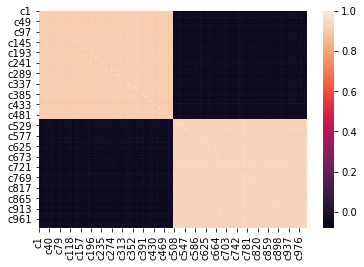

In [43]:
##Looking for correlation between features, i need to remove some, there is too much.


corr = d2.corr()
sns.heatmap(corr)

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))
d2 = d2.drop(d2[to_drop], axis=1)
print(d2.head())

In [44]:

import statsmodels.api as sm
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(d2)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

#Backward Elimination
cols = list(d2.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = d2[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.02):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)



/home/joachim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['c1', 'c9', 'c11', 'c62', 'c70', 'c82', 'c87', 'c88', 'c98', 'c124', 'c131', 'c133', 'c142', 'c145', 'c151', 'c152', 'c178', 'c217', 'c223', 'c230', 'c240', 'c243', 'c250', 'c253', 'c254', 'c259', 'c260', 'c282', 'c296', 'c298', 'c322', 'c325', 'c337', 'c356', 'c375', 'c378', 'c407', 'c409', 'c410', 'c440', 'c476', 'c488', 'c550', 'c560', 'c611', 'c626', 'c674', 'c681', 'c682', 'c716', 'c739', 'c771', 'c794', 'c801', 'c817', 'c938', 'c969', 'c978']


In [45]:
##Get only good features

d2 = d2[selected_features_BE].copy()
print(d2.head())
print(len(selected_features_BE))
print(d2.columns)

             c1            c9           c11           c62           c70  \
0  -1648.461461  -2462.805593  -1112.413855   -556.169205  -4490.435478   
1  -1464.685585  -1995.219014   1966.434568  -4720.822649  -1037.370053   
2  -5225.836447  -2319.697951  -4309.575350    644.719088 -12250.787511   
3 -12288.343091 -10369.113269 -12418.589272 -14349.605488 -17304.145823   
4   3691.352018   4460.889319   3903.652305   6969.670351   1886.095323   

            c82           c87           c88           c98          c124  ...  \
0  -3597.381821  -2648.127887  -6326.781442    120.725086   -302.131189  ...   
1  -3842.402066  -2300.136096  -2831.545106  -2830.823371   -644.175614  ...   
2 -12737.812164  -2140.652029   1295.066212  -6011.435991 -10566.848734  ...   
3 -14327.806281 -14359.471188 -15957.637218 -11848.241725 -11147.193229  ...   
4   3210.661536   6698.829384   5643.177558   6593.100267   5226.236639  ...   

         c682        c716        c739        c771        c794       

In [46]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(d2, y, random_state=42)
scaler = StandardScaler()
scaler.fit(Xtrain2)
Xtrain2 = scaler.transform(Xtrain2)
Xtest2 = scaler.transform(Xtest2)

pca2 = PCA(n_components=2, random_state=42, svd_solver='randomized')
pca2.fit(Xtrain2)
Xtrain2 = pca2.transform(Xtrain2)
Xtest2 = pca2.transform(Xtest2)
print(pca2.explained_variance_ratio_.cumsum())

[0.66072029 0.91776905]


In [47]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(2, include_bias=False)
pf.fit(Xtrain2)
Xtrain_poly = pf.transform(Xtrain2)
Xtest_poly = pf.transform(Xtest2)

##I will not use this, i tried but it's worst


##After i will try 3 model of Regression, but the best one is LinearReg

In [48]:
lr = LinearRegression()
lr.fit(Xtrain2, ytrain2)
y_pred2 = lr.predict(Xtest2)
mse = mean_squared_error(ytest2, y_pred2)
print("lr mse: ", mse)

lr mse:  114.99418042236178


In [15]:
params = {'learning_rate': [0.1, 0.5, 0.01],
              'n_estimators': [7000, 8000, 10000],
              'max_depth': [1, 2, 6],
            'min_samples_split': [0.5, 1.0, 2, 4],
             'min_samples_leaf': [1, 3, 5]}
grid = GridSearchCV(GradientBoostingRegressor(), params, n_jobs=-1)

grid.fit(Xtrain2, ytrain2)
print(grid.best_params_)
print(grid.best_score_)

m = grid.best_estimator_
ypred = m.predict(Xtest2)
mse=mean_squared_error(ytest2, ypred)
print("mse : ", mse)

/home/joachim/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.1, 'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 0.5, 'n_estimators': 10000}
0.9881860364218341
mse :  158.5924896893582


In [16]:
params = {
            'C': [1000, 1050, 1100],
            'epsilon': [8,10,15],
            'gamma': [0.00001, 0.0001, 0.00005]
        }
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=params,
        cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
gsc.fit(Xtrain2, ytrain2)
print(gsc.best_params_)
print(gsc.best_score_)
m = gsc.best_estimator_
ypred = m.predict(Xtest2)
mse=mean_squared_error(ytest2, ypred)
print("mse : ", mse)

{'C': 1100, 'epsilon': 10, 'gamma': 5e-05}
-92.25851699844806
mse :  116.49292376515099


/home/joachim/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
